<a href="https://colab.research.google.com/github/fazaghifari/Notebook-Collections/blob/master/NLP_and_timeseries/Simple_Sentiment_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simple Sentiment Analysis

#### Import stuffs and Check GPU availability

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import imdb
# Check on versioning and gpu usage
print(f"TensorFlow version\t: {tf.__version__}")

# Check on what GPU we use
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

TensorFlow version	: 2.2.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14791752333723830724, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3471162394694313962
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9730432397807353810
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11150726272
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7677746325359492577
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

### Load data from GDrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
file1 = 'reviews.txt'
file2 = 'labels.txt'
folder = '/content/drive/My Drive/datasets/sentiment_class/'
path1 = os.path.join(folder,file1)
path2 = os.path.join(folder,file2)
with open(path1, 'r') as f:
    reviews = f.read()
with open(path2, 'r') as f:
    labels = f.read()

In [4]:
print(reviews[:2000])
print()
print(labels[:26])

bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   
story of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is turn

### Cleaning Data

In [5]:
from string import punctuation

print(punctuation)

# get rid of punctuation
reviews = reviews.lower() # lowercase, standardize
all_text = ''.join([c for c in reviews if c not in punctuation])
sentences = all_text.split('\n') # Split text to list of sentences
all_text = ' '.join(sentences)

# Convert labels to 0 and 1
labels_split = labels.split('\n')
encoded_labels = np.array([1 if label == 'positive' else 0 for label in labels_split])
print(len(sentences))
print(len(encoded_labels))

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
25000
25000


### Tokenize Sentences

In [0]:
embedding_dim = 100
max_length = 200
split_frac = 0.8
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(split_frac * len(sentences))

training_sequences = padded[0:split]
val_sequences = padded[split:len(sentences)]
training_labels = encoded_labels[0:split]
val_labels = encoded_labels[split:len(sentences)]

In [8]:
print(vocab_size)
print(word_index['i'])
print(training_sequences.shape)
print(training_labels.shape)
print(training_sequences[:30,64:74])

74072
10
(20000, 200)
(20000,)
[[    4     1   221   883    31  2988    71     4     1  5787]
 [   38     1   963   142    29   667   123     1 13584   410]
 [  346     5  3090  2092     1 18839 17939    42  8055    46]
 [ 4221    19  1667   922     1  1652     6  6129 19871    34]
 [11723 24106 32305    10   143     3  2360    25   549   287]
 [    1   156    10    43    89    23   122     7     7    19]
 [   24     2     5  1572    12   123     9     3    63    44]
 [  194    51    21   105   106    78    43  1238    40     2]
 [    1   654     5    80    37    19    31     9    31    11]
 [ 2124   354   412     4    13  6609     2  2974  5148  2125]
 [   27  8653     7     7    82  1163  4315   436     2 10628]
 [ 2801     9  8813  4392    19     1 28799  1534 10169    14]
 [ 3268  1624    21     2   131  9507    21   193     5   397]
 [   32     1   333     4   116  9698   183    74     1   171]
 [   13  4049  3903     7     7    21    65   142   558   869]
 [  119   253   134   23

### Download Embedding Layer Weights

To increase the accuracy of the model, we use the pre-trained embedding layer that called GloVe

In [9]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d terenceliu4444/glove6b100dtxt

kaggle.json
glove6b100dtxt.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
!unzip glove6b100dtxt.zip

Archive:  glove6b100dtxt.zip
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
embeddings_index = {};
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [12]:
print(len(embeddings_matrix))

74073


### Define Model

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv1D(256, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 10
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(val_sequences, val_labels), verbose=1)

print("Training Complete")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 100)          7407300   
_________________________________________________________________
dropout_5 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 196, 256)          128256    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 49, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1050624   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

<Figure size 432x288 with 0 Axes>

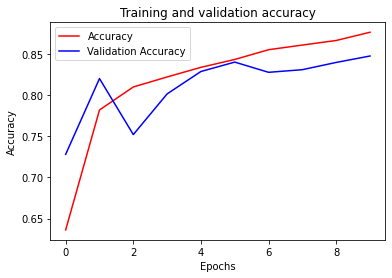

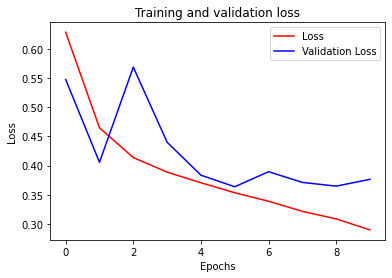

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

### Test on some self-made text

In [0]:
test_rev_neg = "This one is definitely the worst movie I have ever watched. The visual effects are trash and the actors are not professional"
test_rev_pos = "Definitely the best movie I have ever watched. Visual effects are amazing and the plot twist at the end is very unexpected! 10/10 would recommend"
test_rev_rand = "The movie is average. Storyline is very easy to predict, however the visual effects and the acting is good."

In [19]:
sentence = [test_rev_rand]
test_sequence = tokenizer.texts_to_sequences(sentence)
test_padded = pad_sequences(test_sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
output = model.predict(test_padded)
print(output.squeeze())
if(np.round(output.squeeze())==1):
    print("Positive review detected!")
else:
    print("Negative review detected.")

0.9252497
Positive review detected!
